In [ ]:
#| hide
!pip install -Uqq nixtla

In [ ]:
#| hide 
from nixtla.utils import in_colab

In [ ]:
#| hide 
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Univariate vs. Multivariate Anomaly Detection

In this notebook, we show how to detect anomalies across multiple time series using the multivariate method. This method is great for situations where you have several sensors or related time series. We also explain how it works differently from the univariate method.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/capabilities/online-anomaly-detection/03_univariate_vs_multivariate_anomaly_detection')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/capabilities/online-anomaly-detection/03_univariate_vs_multivariate_anomaly_detection.ipynb)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from nixtla import NixtlaClient

In [ ]:
# Utility function to plot anomalies
def plot_anomalies(df, unique_ids, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(12, rows * 2))
    for i, (ax, uid) in enumerate(zip(axes.flatten(), unique_ids)):
        filtered_df = df[df['unique_id'] == uid]
        ax.plot(filtered_df['ts'], filtered_df['y'], color='navy', alpha=0.8, label='y')
        ax.plot(filtered_df['ts'], filtered_df['TimeGPT'], color='orchid', alpha=0.7, label='TimeGPT')
        ax.scatter(filtered_df.loc[filtered_df['anomaly'] == 1, 'ts'], filtered_df.loc[filtered_df['anomaly'] == 1, 'y'], color='orchid', label='Anomalies Detected')
        ax.set_title(f"Unique_id: {uid}", fontsize=8); ax.tick_params(axis='x', labelsize=6)
    fig.legend(loc='upper center', ncol=3, fontsize=8, labels=['y', 'TimeGPT', 'Anomaly'])
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

> 👍 Use an Azure AI endpoint
> 
> To use an Azure AI endpoint, set the `base_url` argument:
> 
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 1. Dataset
In this notebook example from SMD dataset. SMD (Server Machine Dataset) is a benchmark dataset for anomaly detection with multiple time series. It monitors abnormal patterns in server machine data. 

Here, we use a set of monitoring data from a single server machine(machine-1-1) that has 38 time series. Each time series represents a different metric being monitored, such as CPU usage, memory usage, disk I/O, and network I/O. 

In [ ]:
df = pd.read_csv('https://datasets-nixtla.s3.us-east-1.amazonaws.com/SMD_test.csv', parse_dates=['ts'])
df.unique_id.nunique()

38

## 2. Univariate vs. Multivariate Method

### 2.1 Univariate Method
Univariate anomaly detection analyzes each time series independently, flagging anomalies based on deviations from its historical patterns. This method is effective for detecting issues within a single metric but ignores dependencies across multiple series. As a result, it may miss collective anomalies or flag irrelevant ones in scenarios where anomalies arise from patterns across multiple series, such as system-wide failures, correlated financial metrics, or interconnected processes. That’s when multivariate anomaly detection comes into play.

In [ ]:
anomaly_online = nixtla_client.detect_anomalies_online(
    df[['ts', 'y', 'unique_id']],
    time_col='ts',
    target_col='y',
    freq='h',                        
    h=24,                            
    level=95,                        
    detection_size=475,              
    threshold_method = 'univariate'  # Specify the threshold_method as 'univariate'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Online Anomaly Detector Endpoint...


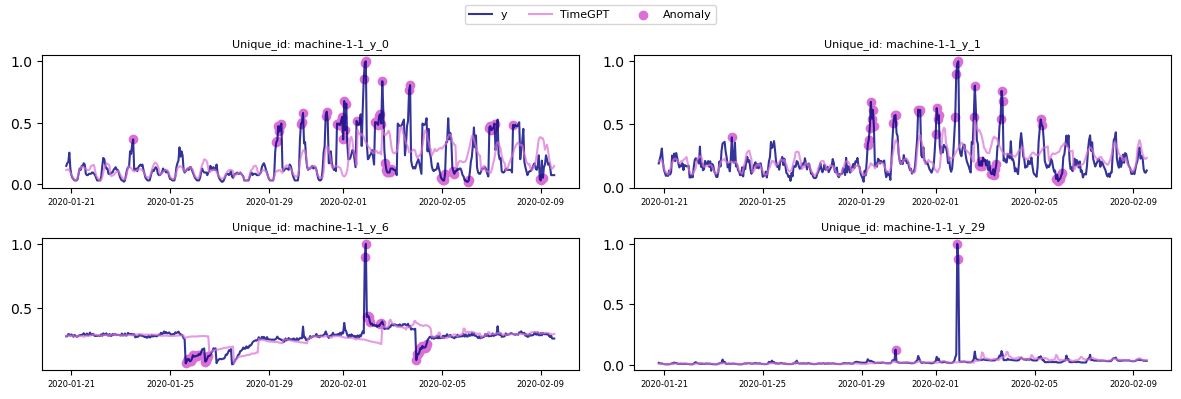

In [ ]:
display_ids = ['machine-1-1_y_0', 'machine-1-1_y_1', 'machine-1-1_y_6', 'machine-1-1_y_29']
plot_anomalies(anomaly_online, display_ids, rows=2, cols=2)

### 2.2 Multivariate Method
The multivariate anomaly detection method considers multiple time series simultaneously. Instead of treating each series in isolation, it accumulates the anomaly scores for the same time step across all series and determines whether the step is anomalous based on the combined score. This method is particularly useful in scenarios where anomalies are only significant when multiple series collectively indicate an issue. To apply multivariate detection, simply set the `threshold_method` parameter to `multivariate`.

We can see that the anomalies detected for each time series occur at the same time step since they rely on the accumulated error across all series.

In [ ]:
anomaly_online_multi = nixtla_client.detect_anomalies_online(
    df[['ts', 'y', 'unique_id']],
    time_col='ts',
    target_col='y',
    freq='h',
    h=24,
    level=95,
    detection_size=475,
    threshold_method = 'multivariate'   # Specify the threshold_method as 'multivariate'
)

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Calling Online Anomaly Detector Endpoint...


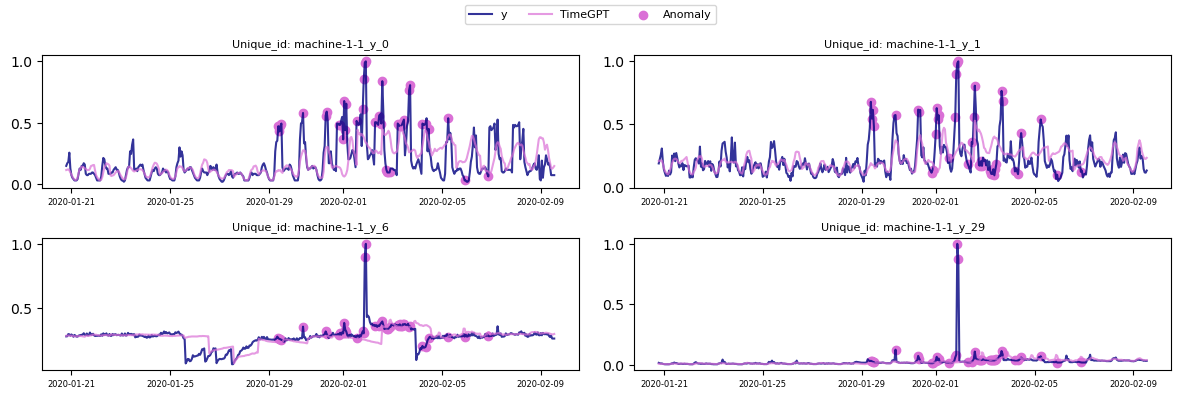

In [ ]:
plot_anomalies(anomaly_online_multi, display_ids, rows=2, cols=2)

> 📘 In multiseries anomaly detection, error scores from all time series are aggregated at each time step, and a threshold is applied to identify significant deviations. If the aggregated error exceeds the threshold, the time step is flagged as anomalous across all series, capturing system-wide patterns.